In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

#### Model 4: Nested GLM

In [2]:
train=pd.read_csv('data/model_train_terr.csv', index_col=0)
test=pd.read_csv('data/model_test_terr.csv', index_col=0)
test['VehGroup_wtd'].fillna(0, inplace=True)

In [3]:
y_col='Cnt'
glm_index=['deviance','bic','aic']
score_index=['RMSE_train','RMSE_test','RMAE_train','RMAE_test']
expr_list=['',' + VehGroup_wtd',' + VehGroup_wtd + State']
cls_list=['cls_0', 'territory_cls']
for cls in cls_list:
    expr_list.append(' + VehGroup_wtd + '+cls)
glm_score=np.zeros((3,len(expr_list)))
score=np.zeros((4,len(expr_list)))
for idx,e in enumerate(expr_list):
    expr_ = "Cnt ~ VehYear + Gender * DrivAge" + e
    FreqPoisson = smf.glm(formula=expr_, data=train, offset=np.log(train['Expo']), 
               family=sm.families.Poisson(link=sm.families.links.Log())).fit()
    pred_test=FreqPoisson.predict(test, offset=np.log(test['Expo']))

    glm_score[:,idx]=[FreqPoisson.deviance, FreqPoisson.bic_llf, FreqPoisson.aic]
    score[:,idx]=[
        MSE(y_true=train[y_col], y_pred=FreqPoisson.fittedvalues, sample_weight=train['Expo']),
        MSE(y_true=test[y_col], y_pred=pred_test, sample_weight=test['Expo']),
        MAE(y_true=train[y_col], y_pred=FreqPoisson.fittedvalues, sample_weight=train['Expo']),
        MAE(y_true=test[y_col], y_pred=pred_test, sample_weight=test['Expo'])
    ]
dfDeviance=pd.DataFrame(glm_score, index=glm_index, columns=expr_list).transpose()
dfError=pd.DataFrame(score, index=score_index, columns=expr_list).transpose()


In [4]:
expr_list[0]='Model_1'
dfDeviance=pd.DataFrame(glm_score, index=glm_index, columns=expr_list).transpose()
dfError=pd.DataFrame(score, index=score_index, columns=expr_list).transpose()
for c in glm_index:
    dfDeviance[c+'_diff']=dfDeviance[c].diff()#-dfDeviance.loc['no_cls',c]
dfDeviance=dfDeviance[np.reshape([glm_index,[c+'_diff' for c in glm_index]], (-1,), order='F')]

for c in score_index:
    dfError[c+'_diff']=dfError[c].diff()#-dfDeviance.loc['no_cls',c]
dfError=dfError[np.reshape([score_index,[c+'_diff' for c in score_index]], (-1,), order='F')]

display(dfDeviance.round(decimals=0))
display(dfError.round(decimals=6))

,deviance,deviance_diff,bic,bic_diff,aic,aic_diff
Model_1,208167.0,NaN,337418.0,NaN,337288.0,NaN
+ VehGroup_wtd,205215.0,-2952.0,334479.0,-2938.0,334338.0,-2950.0
+ VehGroup_wtd + State,204192.0,-1024.0,333814.0,-666.0,333367.0,-972.0
+ VehGroup_wtd + cls_0,204202.0,10.0,333783.0,-31.0,333371.0,4.0
+ VehGroup_wtd + territory_cls,205060.0,858.0,334338.0,555.0,334185.0,814.0


,RMSE_train,RMSE_train_diff,RMSE_test,RMSE_test_diff,RMAE_train,RMAE_train_diff,RMAE_test,RMAE_test_diff
Model_1,0.034686,NaN,0.034609,NaN,0.090924,NaN,0.090956,NaN
+ VehGroup_wtd,0.034480,-0.000205,0.034418,-0.000190,0.089737,-0.001186,0.089818,-0.001138
+ VehGroup_wtd + State,0.034373,-0.000108,0.034304,-0.000114,0.089473,-0.000264,0.089536,-0.000282
+ VehGroup_wtd + cls_0,0.034372,-0.000000,0.034305,0.000001,0.089470,-0.000003,0.089534,-0.000002
+ VehGroup_wtd + territory_cls,0.034462,0.000089,0.034394,0.000089,0.089687,0.000217,0.089762,0.000228


In [5]:
test.shape

(407876, 16)

In [6]:
expr_list[0]='Model_1'
dfDeviance=pd.melt(pd.DataFrame(glm_score, index=glm_index, columns=expr_list).reset_index(),
        id_vars=['index'], value_vars=expr_list)

dfError=pd.melt(pd.DataFrame(score, index=score_index, columns=expr_list).reset_index(),
        id_vars=['index'], value_vars=expr_list)


(183772.56105236948, 506126.6709104808)

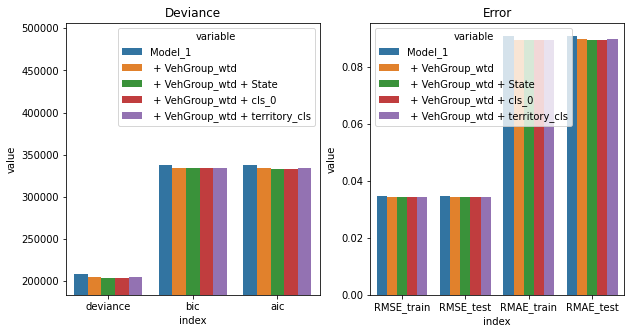

In [7]:
fig,axs=plt.subplots(1,2,figsize=(5*2,5*1),sharex=False, sharey=False)
sns.barplot(data=dfDeviance, x='index', y='value', hue='variable', ax=axs[0]).set(title='Deviance')
sns.barplot(data=dfError, x='index', y='value', hue='variable', ax=axs[1]).set(title='Error')
axs[0].set_ylim(glm_score.min()*.9,glm_score.max()*1.5)